# Visual check of predictions

In [1]:
import torch

In [2]:
import sys
sys.path.insert(0, "../code/deeplab")
sys.path.insert(0, "../code/deeplab/configs/train/")

In [3]:
from baseline_r18_softmax import device, model, val_loader, prepare_batch, non_blocking

In [5]:
# state_dict = torch.load("../code/output/best_model_1.pth")
# model.load_state_dict(state_dict)

model.to(device)
model = model.eval()

In [6]:
for batch in val_loader:
    break

In [7]:
x, y = prepare_batch(batch, device, non_blocking)

y_probas = model(x)
y_probas.shape

torch.Size([128, 21, 224, 224])

In [10]:
indices = torch.randperm(x.shape[0])[:15]

In [11]:
x[indices, ...].shape 

torch.Size([15, 3, 224, 224])

In [8]:
import numpy as np
from torchvision.utils import make_grid

In [12]:
def _getvocpallete(num_cls):
    n = num_cls
    pallete = [0]*(n*3)
    for j in range(0, n):
        lab = j
        pallete[j*3+0] = 0
        pallete[j*3+1] = 0
        pallete[j*3+2] = 0
        i = 0
        while (lab > 0):
            pallete[j*3+0] |= (((lab >> 0) & 1) << (7-i))
            pallete[j*3+1] |= (((lab >> 1) & 1) << (7-i))
            pallete[j*3+2] |= (((lab >> 2) & 1) << (7-i))
            i = i + 1
            lab >>= 3
    return pallete

vocpallete = _getvocpallete(256)

In [55]:
from PIL import Image
from image_dataset_viz import render_datapoint


def render_x(x, nrow=5):
    bg_imgs = make_grid(x, normalize=True, nrow=nrow)
    bg_imgs = bg_imgs.cpu().numpy()
    return (bg_imgs.transpose((1, 2, 0)) * 255).astype(np.uint8)

def render_y(y, nrow=5):
    segm_imgs = make_grid(y.unsqueeze(dim=1), nrow=nrow)
    segm_imgs = segm_imgs[0, :, :].cpu().numpy()
    segm_imgs = Image.fromarray(segm_imgs.astype(np.uint8))
    segm_imgs.putpalette(vocpallete)
    return segm_imgs.convert('RGB')
        

def predictions_gt_images_handler(n_images=15, n_rows=5, single_img_size=None, another_engine=None):
    
    def wrapper(engine, writer, state_attr):
        output = engine.state.output
        x, y_pred, y = output['x'], output['y_pred'], output['y']
        _, y_pred = torch.max(y_pred, dim=1)

        bg_imgs = render_x(x[:n_images, ...], nrow=n_rows)
        pred_imgs = render_y(y_pred[:n_images, ...], nrow=n_rows)
        gt_imgs = render_y(y[:n_images, ...], nrow=n_rows)
        
        img1 = np.asarray(render_datapoint(bg_imgs, pred_imgs, output_size=single_img_size))
        img2 = np.asarray(render_datapoint(bg_imgs, gt_imgs, output_size=single_img_size))
        
        state = engine.state if another_engine is None else another_engine.state
        global_step = getattr(state, state_attr)
        
        writer.add_image(tag="predictions", img_tensor=img1, global_step=global_step, dataformats='HWC')
        writer.add_image(tag="ground-truth", img_tensor=img2, global_step=global_step, dataformats='HWC')
    
    return wrapper

In [49]:
res = render_x(x[:15, ...])

In [51]:
_, y_pred = torch.max(y_probas, dim=1)

res1 = render_y(y_pred[:15, ...])
res2 = render_y(y[:15, ...])

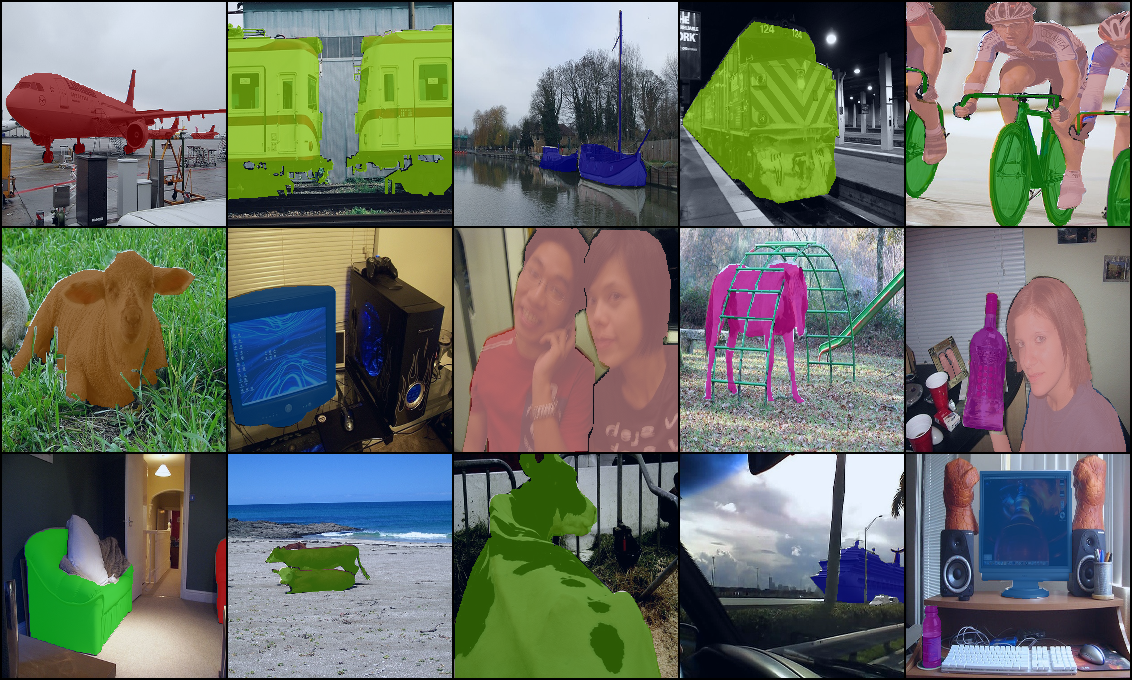

In [52]:
render_datapoint(res, res2)

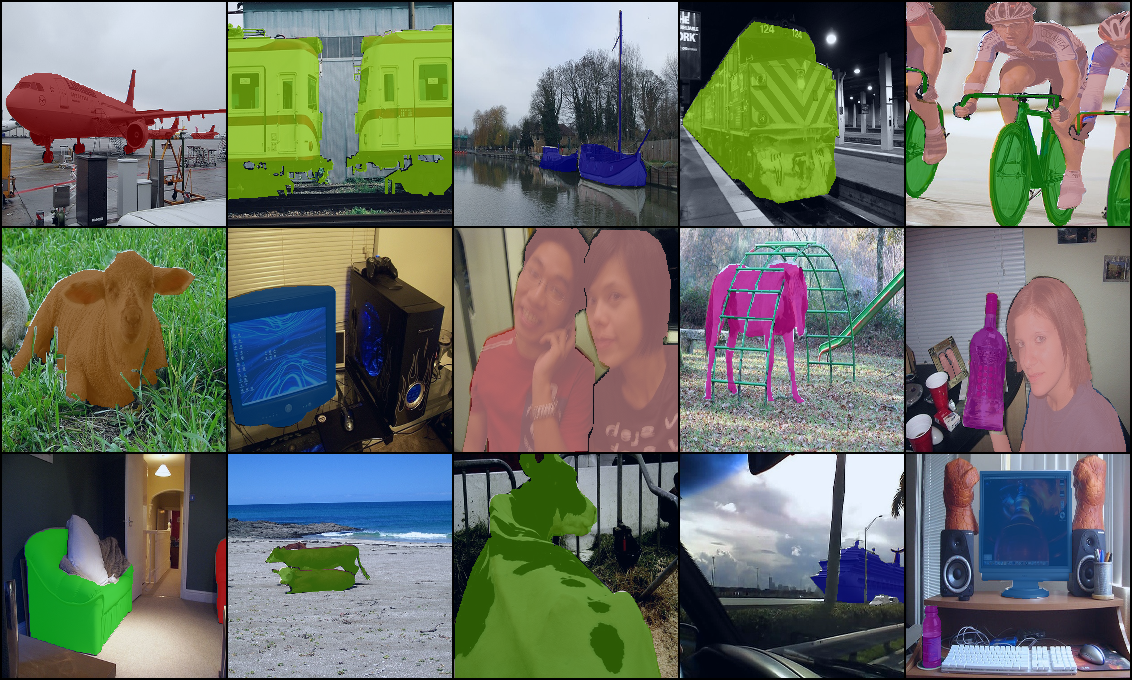

In [54]:
render_datapoint(res, res2)